This notebook to demo's the use of the pretrained HuggingFace tokenizers and transformers with the new **fastai-v2** library.

### Pretrained Transformers only for now
Initially, this notebook will only deal with finetuning HuggingFace's pretrained models. It covers BERT, DistilBERT, RoBERTa and ALBERT pretrained classification models only. These are the core transformer model architectures where HuggingFace have added a classification head. HuggingFace also has other versions of these model architectures such as the core model architecture and language model model architectures.

If you'd like to try train a model from scratch HuggingFace just recently published an article on [How to train a new language model from scratch using Transformers and Tokenizers](https://huggingface.co/blog/how-to-train). Its well worth reading to see how their `tokenizers` library can be used, independent of their pretrained transformer models.

### Read these first 👇
This notebooks heavily borrows from [this notebook](https://www.kaggle.com/melissarajaram/roberta-fastai-huggingface-transformers) , which in turn is based off of this [tutorial](https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta) and accompanying [article](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2). Huge thanks to  Melissa Rajaram and Maximilien Roberti for these great resources, if you're not familiar with the HuggingFace library please 

### fastai-v2
[This paper](https://www.fast.ai/2020/02/13/fastai-A-Layered-API-for-Deep-Learning/) introduces the v2 version of the fastai library and you can follow and contribute to v2's progress [on the forums](https://forums.fast.ai/). This notebook is based off the [fastai-v2 ULMFiT tutorial](http://dev.fast.ai/tutorial.ulmfit). Huge thanks to Jeremy, Sylvain, Rachel and the fastai community for making this library what it is. I'm super excited about the additinal flexibility v2 brings.

### Dependencies
If you haven't already, install HuggingFace's `transformers` library with: `pip install transformers`

# Lets Go!

In [1]:
# CUDA ERROR DEBUGGING
# https://lernapparat.de/debug-device-assert/
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
%reload_ext autoreload
%autoreload 2

from fastai2.basics import *
from fastai2.text.all import *
from fastai2.callback.all import *

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig

import json

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
model_path = Path('models')
df = pd.read_csv(path/'texts.csv')

### Prepare HuggingFace model classes

In [4]:
models_dict = {'bert_classification': (BertForSequenceClassification, BertTokenizer, BertConfig),
                'roberta_classification': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
                'distilbert_classification': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
                'albert_classification': (AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig)
              }

In [5]:
model_type = 'bert_classification'   
pretrained_model_name = 'bert-base-uncased'  # roberta-base

# model_type = 'roberta_classification'   
# pretrained_model_name = 'roberta-base'

# model_type = 'distilbert_classification'   
# pretrained_model_name = 'distilbert-base-uncased'

model_class, tokenizer_class, config_class = models_dict[model_type]

### Get Tokenizer from HuggingFace
Intialise the tokenizer needed for the pretrained model, this will download the `vocab.json` and `merges.txt` files needed. Specifying `cache_dir` will allow us easily access them, otherwise they will be saved to a Torch cache folder here `~/.cache/torch/transformers`. 

In [6]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name, 
                                                        cache_dir=model_path/f'{pretrained_model_name}')

 Model and vocab files will be saved with files names as a long string of digits and letters (e.g. `d9fc1956a0....f4cfdb5feda.json` generated from the etag from the AWS S3 bucket as described [here in the HuggingFace repo](https://github.com/huggingface/transformers/issues/2157). For readability I prefer to save the files in a specified directory and model name so that it can be easily found and accessed in future.
 
To avoid saving these files twice you could look at the `from_pretrained` and `cached_path` functions in HuggingFace's `PreTrainedTokenizer` class definition to find the code that downloads the files and maybe modify them to download directly to your specified directory withe desired name

In [7]:
# TODO: Figure out how to give files model-specific names in case of using different transformers
transformer_tokenizer.save_vocabulary(model_path/f'{pretrained_model_name}')

('models/bert-base-uncased/vocab.txt',)

Load vocab file into a list as expected by fastai-v2. BERT's vocab is saved as a .txt file where as RoBERTa's is saved as a .json

In [8]:
if pretrained_model_name=='bert-base-uncased': 
    suff = 'txt'
else: 
    suff = 'json'

with open(model_path/f'{pretrained_model_name}/vocab.{suff}', 'r') as f: 
    if pretrained_model_name=='bert-base-uncased':
        transformer_vocab = f.read()
    else:
        transformer_vocab = list(json.load(f).keys()) 

### Custom FastHugs Tokenizer
Now that we have our vocab list, can look to incorporate HuggingFaces pretrained transformer tokenizers into fastai-v2's framework

In [9]:
class FastHugsTokenizer():
    def __init__(self, pretrained_tokenizer = transformer_tokenizer, model_type = 'roberta', **kwargs):        
        self.tok = transformer_tokenizer
        self.max_seq_len = self.tok.max_len
        self.model_type = model_type
        self.pad_token_id = self.tok.pad_token_id
        
    def do_tokenize(self, t:str):
        """Limits the maximum sequence length and add the special tokens"""
        CLS = self.tok.cls_token
        SEP = self.tok.sep_token
        if 'roberta' in model_type:
            tokens = self.tok.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self.tok.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

    def __call__(self, items): 
        for t in items: yield self.do_tokenize(t)

In [10]:
# Pass empty `rules` and `post_rules` list so fastai rules are not applied

fasthugstok = partial(FastHugsTokenizer, pretrained_tokenizer = transformer_tokenizer, model_type=model_type)

tok_fn = Tokenizer.from_df(text_cols='text', res_col_name='text', 
                           tok_func=fasthugstok,
                           rules=[], post_rules=[])

In [11]:
jj = FastHugsTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type=model_type)

In [12]:
jj.max_seq_len

512

### Create Dataset
Lets add our custom tokenizer function (`tok_fn`) and `transformer_vocab` here

In [13]:
splits = ColSplitter()(df)
x_tfms = [attrgetter("text"), tok_fn, Numericalize(vocab=transformer_vocab)]
dsets = Datasets(df, splits=splits, tfms=[x_tfms, [attrgetter("label"), Categorize()]], dl_type=SortedDL)

### Create Dataloaders
**Padding**: BERT, Roberta prefers padding to the right, so we set `pad_first=False`

In [14]:
def transformer_padding(transformer_tokenizer): 
    if transformer_tokenizer.padding_side == 'right': 
        pad_first=False
    return partial(pad_input_chunk, pad_first=pad_first, pad_idx=transformer_tokenizer.pad_token_id)

In [17]:
transformer_tokenizer.pad_token_id

0

Load you dataloader

In [18]:
bs = 2
dls = dsets.dataloaders(bs=bs, device='cuda', before_batch=transformer_padding(transformer_tokenizer))
#dls = dsets.dataloaders(bs=bs, before_batch=pad_input_chunk)

In [19]:
dls.show_batch()

,text,category
0,"[ i [ [ [ [ [ [ [ ( [ [ [ [ [ : t [ [ [ [ [ [ [ [ ) [ a [ [ [ [ [ , [ [ [ [ [ [ [ [ [ [ "" [ "" . [ [ [ [ , [ [ [ [ [ [ [ [ [ [ [ [ [ "" [ [ "" [ [ "" [ [ [ [ [ a [ [ "" . i [ [ [ [ [ [ [ [ [ a [ [ [ [ [ a [ ( [ [ [ [ [ [ [ [ [ [ [ [ [ ? i [ [ a [ [ [ [ [ [ [ ) , [ [ [ [ [ [ [ [ . < [ / > < [ / > [ [ [ [",negative
1,"[ [ [ [ a [ [ [ [ [ [ [ [ [ [ , [ [ [ [ [ [ , [ [ [ [ [ [ [ [ . [ [ [ [ [ a [ [ [ a [ [ [ [ , [ [ [ ' [ [ [ ( [ [ [ [ ) , [ [ [ [ [ [ [ [ [ [ [ [ [ . . . [ [ [ [ [ [ , [ , [ [ - [ [ [ . < [ / > < [ / > [ [ [ [ [ [ [ ( [ [ [ [ ) [ [ [ [ [ e . [ [ [ [ [ [ , [ [ [ [ ( [ [ b [ [ [ [ ) [ [ [ [ . [ [ [ '",negative


In [16]:
dsets.train.items.iloc[58:69] #head()

,label,is_valid,text,text_length
58,positive,False,"[[CLS], jack, frost, is, really, a, cool, movie, ., i, mean, ., ., ., ., its, funny, ., its, violent, ., and, very, enjoyable, ., most, people, say, that, it, is, b, rated, ,, but, that, couldn, ', t, be, farther, from, the, truth, ., it, has, great, special, effects, and, good, acting, ., the, only, weird, thing, is, of, course, ,, the, killer, snow, ##man, ., i, think, this, movie, was, actually, one, of, the, best, films, of, the, late, -, nine, ##ties, ., most, films, these, days, lack, the, criteria, of, a, clive, barker, master, piece, ., that, ...]",144
59,negative,False,"[[CLS], devil, hunter, gained, notoriety, for, the, fact, that, it, ', s, on, the, d, ##pp, ', video, nasty, ', list, ,, but, it, really, need, ##n, ', t, have, been, ., many, films, on, the, list, where, there, for, god, (, and, d, ##pp, ), only, known, reasons, ,, and, while, this, isn, ', t, the, tame, ##st, of, the, bunch, ;, there, isn, ', t, a, lot, here, that, warrant, ##s, banning, ., ., ., which, is, a, shame, because, i, never, would, have, sat, through, it, where, it, not, for, the, fact, that, it, ', s, on, ...]",358
60,negative,False,"[[CLS], i, managed, to, grab, a, viewing, of, this, with, the, aid, of, ms, ##t, ##3, ##k, ,, and, oh, boy, ,, even, with, the, riff, ##ing, this, movie, was, ex, ##cr, ##uc, ##iating, ##ly, bad, ., imagine, someone, whose, competence, with, a, camera, could, be, out, done, by, a, monkey, ., <, br, /, >, <, br, /, >, the, highlights, (, what, little, there, were, ), came, from, the, special, effects, ,, which, were, "", ok, "", ., the, acting, for, the, most, part, was, also, "", ok, "", ;, though, nothing, special, ,, it, was, of, a, ...]",258
61,positive,False,"[[CLS], the, year, 2005, saw, no, fewer, than, 3, filmed, productions, of, h, ., g, ., wells, ', great, novel, ,, "", war, of, the, worlds, "", ., this, is, perhaps, the, least, well, -, known, and, very, probably, the, best, of, them, ., no, other, version, of, wo, ##t, ##w, has, ever, attempted, not, only, to, present, the, story, very, much, as, wells, wrote, it, ,, but, also, to, create, the, atmosphere, of, the, time, in, which, it, was, supposed, to, take, place, :, the, last, year, of, the, 19th, century, ,, 1900, using, wells, ', original, setting, ,, ...]",512
62,negative,False,"[[CLS], i, tend, to, love, everything, the, great, late, paul, nas, ##chy, (, r, ., i, ., p, ., ), ever, was, in, ., while, not, all, films, starring, nas, ##chy, are, great, ,, they, all, have, a, specific, charm, that, can, be, found, nowhere, but, in, nas, ##chy, -, flick, ##s, ,, and, they, are, always, entertaining, ., there, is, no, rule, without, exception, ,, however, ,, as, "", el, maris, ##cal, del, in, ##fi, ##ern, ##o, "", aka, ., "", the, devil, ', s, possessed, "", (, 1974, ), proves, ., while, the, film, does, have, the, specific, ...]",512
63,negative,False,"[[CLS], i, read, this, thornton, wilder, play, last, year, in, eighth, grade, ., i, was, also, forced, to, sit, through, this, weak, translation, of, it, on, screen, ., let, me, tell, you, ,, it, ', s, not, a, terrific, play, ,, it, is, easily, surpassed, ,, but, man, it, deserves, a, much, better, shot, ., the, acting, was, really, lacking, ,, the, scenery, -, honest, to, god, -, looked, like, it, was, designed, out, of, cardboard, by, a, group, of, three, -, year, -, olds, ., as, if, it, couldn, ', t, get, worse, ,, the, sound, quality, is, lou, ...]",242
64,negative,False,"[[CLS], please, ,, someone, stop, ben, still, ##er, from, acting, in, any, movie, ., write, the, studios, ,, hell, ,, write, your, local, congressman, even, ., i, ', ve, gotten, more, laughs, going, to, a, funeral, then, i, have, watching, any, still, ##er, flick, ., jack, black, tries, to, make, something, about, a, comedy, about, disappearing, dog, crap, ,, and, christopher, walk, ##en, ,, perhaps, on, of, the, greatest, actors, of, his, generation, ,, simply, looks, embar

In [17]:
dls.show_batch(max_n=2, trunc_at=60)

,text,category
0,"[ i [ [ [ [ [ [ [ ( [ [ [ [ [ : t [ [ [ [ [ [ [ [ ) [ a [ [ [ [ [ , [ [ [ [ [ [ [ [ [ [ "" [ "" . [ [ [ [ , [ [ [ [ [ [ [",negative
1,"[ [ [ : * * * * * [ [ * * * * [ [ * * * [ [ * * [ [ * [ [ < [ / > < [ / > [ ( [ [ [ ) [ a [ [ , [ [ [ [ [ [ [ [ [ a [ [",negative


In [18]:
y = dls.one_batch()
y[0].size(), y[1].size()

(torch.Size([2, 512]), torch.Size([2]))

In [19]:
y[0][1]

tensor([     0,      0,      0,      0,      0,      0, 224564,      0,      0,
        224564,      0,      0,      0,      0,      0,      0,      0,      0,
        224623, 224599, 224562, 224595, 224533,      0,      0,      0,      0,
        224623, 224603,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0, 224615,      0,      0,      0,      0,      0,
             0,      0, 224623,      0,      0,      0,      0,      0,      0,
             0,      0, 224564,      0,      0,      0,      0, 224615,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
        224575,      0,      0,      0,      0,      0,      0,      0,      0,
        224564,      0,      0,      0,      0,      0, 224575,      0,      0,
             0,      0,      0,      0,      0,      0,      0, 224623, 224639,
             0, 224627, 224647, 224639,      0, 224627, 224647, 224564,      0,
             0,      0,      0,      0, 

Factory dataloader. Here we set:
- `tok_tfm=tok_fn` to get our custom tokenizer
- `text_vocab=transformer_vocab` to load our pretrained vocab
- `before_batch=transformer_padding(transformer_tokenizer)` to make sure we set padding as the pretrained model expects

In [20]:
# Factory
fct_dls = TextDataLoaders.from_df(df, text_col="text", tok_tfm=tok_fn, text_vocab=transformer_vocab,
                              before_batch=transformer_padding(transformer_tokenizer),
                              label_col='label', valid_col='is_valid', bs=bs)

In [21]:
fct_dls.show_batch(max_n=2, trunc_at=60)

,text,category
0,"[ i [ [ [ [ [ [ [ ( [ [ [ [ [ : t [ [ [ [ [ [ [ [ ) [ a [ [ [ [ [ , [ [ [ [ [ [ [ [ [ [ "" [ "" . [ [ [ [ , [ [ [ [ [ [ [",negative
1,"[ [ [ [ [ [ [ [ [ . [ [ [ , [ [ , [ [ [ , [ [ [ [ [ [ [ [ [ [ [ [ [ . [ [ [ [ [ [ [ [ , [ [ [ [ [ [ [ [ [ a [ [ [ [ [ [",positive


### Load HuggingFace models

In [22]:
# More or less copy past from https://www.kaggle.com/melissarajaram/roberta-fastai-huggingface-transformers/data
class FastHugsModel(nn.Module):
    def __init__(self, transformer_model):
        super(FastHugsModel, self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=1).type(input_ids.type()) # attention_mask for RoBERTa
        print(input_ids.size())
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0] 
        print(logits.size())
        return logits

### Model Setup - Model Splitters
HuggingFace's models with names such as: `RobertaForSequenceClassification` are core trasnformer models with a classification head. Lets split the classification head from the core transformer backbone to enable us use progressive unfreezing and differential learning rates.

**Classification Head Differences**

Interestingly, BERT's classification head is different to RoBERTa's

BERT's:

`
(dropout): Dropout(p=0.1, inplace=False)
(classifier): Linear(in_features=768, out_features=2, bias=True)
`

DistilBERT's has a "pre-classifier" layer:

`
(pre_classifier): Linear(in_features=768, out_features=768, bias=True)
(classifier): Linear(in_features=768, out_features=2, bias=True)
(dropout): Dropout(p=0.2, inplace=False)`

RoBERTa's:

`(classifier): RobertaClassificationHead(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (out_proj): Linear(in_features=768, out_features=2, bias=True))`

In [23]:
def bert_clas_splitter(m):
    "Split the classifier head from the backbone"
    groups = [nn.Sequential(m.transformer.bert.embeddings,
                m.transformer.bert.encoder.layer[0],
                m.transformer.bert.encoder.layer[1],
                m.transformer.bert.encoder.layer[2],
                m.transformer.bert.encoder.layer[3],
                m.transformer.bert.encoder.layer[4],
                m.transformer.bert.encoder.layer[5],
                m.transformer.bert.encoder.layer[6],
                m.transformer.bert.encoder.layer[7],
                m.transformer.bert.encoder.layer[8],
                m.transformer.bert.encoder.layer[9],
                m.transformer.bert.encoder.layer[10],
                m.transformer.bert.encoder.layer[11],
                m.transformer.bert.pooler)]
    groups = L(groups + [m.transformer.classifier]) 
    return groups.map(params)

In [24]:
def distilbert_clas_splitter(m):
    groups = [nn.Sequential(m.embeddings,
                m.transformer.layer[0],
                m.transformer.layer[1],
                m.transformer.layer[2],
                m.transformer.layer[3],
                m.transformer.layer[4],
                m.transformer.layer[6],
                m.pre_classifier)]
    groups = L(groups + [m.classifier]) 
    return groups.map(params)

In [25]:
def roberta_clas_splitter(m):
    "Split the classifier head from the backbone"
    groups = [nn.Sequential(m.transformer.roberta.embeddings,
                  m.transformer.roberta.encoder.layer[0],
                  m.transformer.roberta.encoder.layer[1],
                  m.transformer.roberta.encoder.layer[2],
                  m.transformer.roberta.encoder.layer[3],
                  m.transformer.roberta.encoder.layer[4],
                  m.transformer.roberta.encoder.layer[5],
                  m.transformer.roberta.encoder.layer[6],
                  m.transformer.roberta.encoder.layer[7],
                  m.transformer.roberta.encoder.layer[8],
                  m.transformer.roberta.encoder.layer[9],
                  m.transformer.roberta.encoder.layer[10],
                  m.transformer.roberta.encoder.layer[11],
                  m.transformer.roberta.pooler)]
    groups = L(groups + [m.transformer.classifier])
    return groups.map(params)

### Load Model with configs

Here we can tweak the HuggingFace model's config file before loading the model

In [26]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.save_pretrained(model_path/f'{pretrained_model_name}') 

In [27]:
model = model_class.from_pretrained(pretrained_model_name, config = config, 
                                    cache_dir=model_path/f'{pretrained_model_name}')
model.save_pretrained(model_path/f'{pretrained_model_name}')

In [28]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [29]:
dd = [p[0] for p in model.named_parameters() if p[1].requires_grad]
dd

['bert.embeddings.word_embeddings.weight',
 'bert.embeddings.position_embeddings.weight',
 'bert.embeddings.token_type_embeddings.weight',
 'bert.embeddings.LayerNorm.weight',
 'bert.embeddings.LayerNorm.bias',
 'bert.encoder.layer.0.attention.self.query.weight',
 'bert.encoder.layer.0.attention.self.query.bias',
 'bert.encoder.layer.0.attention.self.key.weight',
 'bert.encoder.layer.0.attention.self.key.bias',
 'bert.encoder.layer.0.attention.self.value.weight',
 'bert.encoder.layer.0.attention.self.value.bias',
 'bert.encoder.layer.0.attention.output.dense.weight',
 'bert.encoder.layer.0.attention.output.dense.bias',
 'bert.encoder.layer.0.attention.output.LayerNorm.weight',
 'bert.encoder.layer.0.attention.output.LayerNorm.bias',
 'bert.encoder.layer.0.intermediate.dense.weight',
 'bert.encoder.layer.0.intermediate.dense.bias',
 'bert.encoder.layer.0.output.dense.weight',
 'bert.encoder.layer.0.output.dense.bias',
 'bert.encoder.layer.0.output.LayerNorm.weight',
 'bert.encoder.layer

Initialise everything our Learner

In [30]:
fasthugs_model = FastHugsModel(transformer_model = model)

opt_func = partial(Adam, decouple_wd=True)

cbs = [MixedPrecision(clip=0.1), SaveModelCallback()]

loss = CrossEntropyLossFlat() #LabelSmoothingCrossEntropy

### Create our learner

In [31]:
#dls.one_batch()

In [32]:
learn = Learner(dls, fasthugs_model, opt_func=opt_func, # splitter=bert_clas_splitter, # roberta_clas_splitter,
                   loss_func=loss, metrics=[accuracy])

In [33]:
#learn.show_training_loop()

In [36]:
dsets.c

2

In [37]:
learn.lr_find(suggestions=True)

torch.Size([2, 512])


RuntimeError: CUDA error: device-side assert triggered

### Stage 1 Training
Lets freeze the model backbone and only train the classifier head. `freeze_to(1)` means that only the classifier head is trainable

In [29]:
#learn.model.transformer.

In [30]:
learn.freeze_to(1)  

In [32]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(input_ids, labels=labels)

#loss, logits = outputs[:2]

outputs

(tensor(0.8255, grad_fn=<NllLossBackward>),
 tensor([[0.4643, 0.2150]], grad_fn=<AddmmBackward>))

In [34]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(input_ids, labels=labels)
outputs
#loss, logits = outputs[:2]

(tensor(0.7342, grad_fn=<NllLossBackward>),
 tensor([[-0.0375, -0.1180]], grad_fn=<AddmmBackward>))

In [30]:
learn.summary()

RuntimeError: cublas runtime error : library not initialized at /opt/conda/conda-bld/pytorch_1573049306803/work/aten/src/THC/THCGeneral.cpp:216

Lets find a learning rate to train our classifier head

In [29]:
learn.lr_find(suggestions=True)

torch.Size([2, 512])


RuntimeError: CUDA error: device-side assert triggered

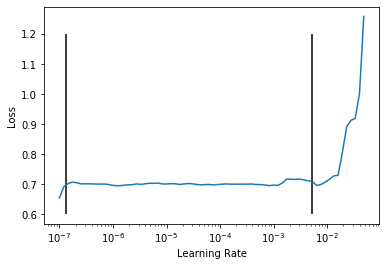

In [25]:
learn.recorder.plot_lr_find()
plt.vlines(1.318e-07, 0.6, 1.2)
plt.vlines(0.00524, 0.6, 1.2)

In [26]:
learn.fit_one_cycle(3, lr_max=1e-3, div=10)

epoch,train_loss,valid_loss,accuracy,time
0,0.703972,0.685084,0.465000,00:10
1,0.595791,0.555975,0.790000,00:09
2,0.497009,0.511307,0.820000,00:09


In [27]:
learn.save('roberta-fasthugs-stg1-1e-3')

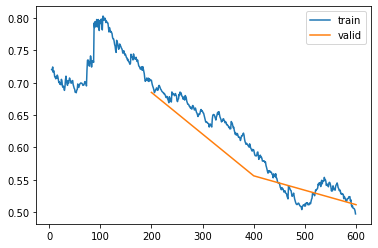

In [28]:
learn.recorder.plot_loss()

### Stage 2 Training
And now lets train the full model with differential learning rates

In [29]:
learn.unfreeze()

(1.584893179824576e-05, 0.0008317637839354575)

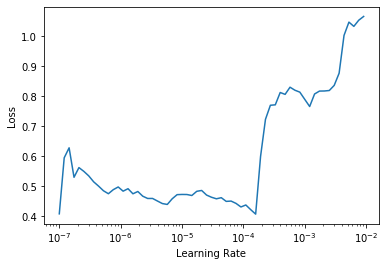

In [30]:
learn.lr_find(suggestions=True)

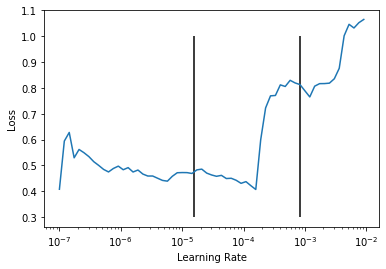

In [31]:
learn.recorder.plot_lr_find()
plt.vlines(1.584e-05, 0.3, 1.0)
plt.vlines(0.0008317, 0.3, 1.0)

In [32]:
learn.fit_one_cycle(3, lr_max=slice(1e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.417611,0.400168,0.880000,00:28
1,0.276386,0.295171,0.900000,00:28
2,0.234433,0.282703,0.900000,00:29


In [33]:
learn.save('roberta-fasthugs-stg2-3e-5')

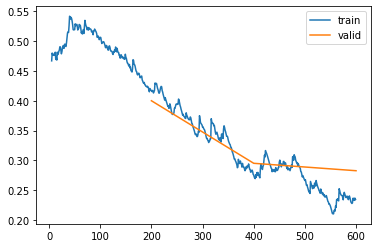

In [34]:
learn.recorder.plot_loss()

## Lets Look at the model's predictions

In [35]:
learn.predict("This was a good movie")

('positive', tensor(1), tensor([0.1585, 0.8415]))

In [36]:
from fastai2.interpret import *
interp = Interpretation.from_learner(learn)

In [37]:
interp.plot_top_losses(5)

,input,target,predicted,probability,loss
0,"<s> ĠIn Ġ17 th ĠCentury ĠJapan , Ġthere Ġlived Ġa Ġsamurai Ġwho Ġwould Ġset Ġthe Ġstandard Ġfor Ġthe Ġages . ĠHis Ġname Ġwas ĠMay eda . ĠHe Ġis Ġsent Ġon Ġan Ġepic Ġjourney Ġacross Ġthe Ġworld Ġto Ġacquire Ġ5 , 000 Ġmus cats Ġfrom Ġthe ĠKing Ġof ĠSpain . ĠWhilst Ġat Ġsea Ġa Ġviolent Ġstorm Ġswall ows Ġtheir Ġprecious Ġgold Ġintended Ġto Ġbuy Ġthe Ġweapons Ġand Ġalmost Ġtakes Ġtheir Ġlives . ĠMay eda Ġmust Ġbattle Ġall Ġodds Ġto Ġsurvive Ġand Ġthe Ġsecure Ġthe Ġfate Ġof Ġhis Ġbeloved ĠJapan . ĠShogun ĠMay eda Ġis Ġa Ġmulti Ġmillion Ġdollar Ġaction Ġadventure Ġepic Ġset Ġacross Ġthree Ġcontinents .< br Ġ/ >< br Ġ/> Star ring Ġcinema Ġlegends ĠSho ĠKos ugi Ġ( T ench u : ĠStealth ĠAssassins ), ĠChristopher ĠLee Ġ( Star ĠWars , ĠLord Ġof Ġthe ĠRings ĠTrilogy ), ĠJohn ĠRh ys ĠDavies Ġ( Lord Ġof Ġthe ĠRings ĠTrilogy , ĠIndiana ĠJones",negative,positive,0.9690422415733337,3.475131034851074
1,"<s> ĠI 'm Ġgonna Ġtip Ġthe Ġscales Ġhere Ġa Ġbit Ġand Ġsay ĠI Ġenjoyed Ġthis . ĠHowever , Ġthe Ġcartoon Ġis Ġreally Ġonly Ġgoing Ġto Ġappeal Ġto Ġthose Ġwho Ġhave Ġvery Ġabsurd ist Ġtendencies . ĠIt 's Ġdefinitely Ġsomething Ġthat Ġmost Ġpeople Ġwill Ġnot Ġget , Ġas Ġis Ġthe Ġnature Ġof Ġabsurd ism .< br Ġ/ >< br Ġ/> the Ġanimation Ġis Ġhorrible , Ġbut Ġyes , Ġthat 's Ġthe Ġpoint . ĠThe Ġmain Ġcharacter Ġis Ġfoul Ġm out hed , Ġviolent , Ġand Ġstupid . Ġno Ġredeem ing Ġqualities Ġwhatsoever . Ġhis Ġwife Ġshri eks Ġand Ġw ails , Ġapparently Ġjust Ġbarely Ġcapable Ġof Ġthe Ġmost Ġbasic Ġcommunication Ġskills . Ġmost Ġof Ġthese Ġstories Ġcompletely Ġlack Ġany Ġkind Ġof Ġpoint .< br Ġ/ >< br Ġ/> but Ġagain , Ġthat 's Ġthe Ġpoint Ġ;) < br Ġ/ >< br Ġ/> If Ġnon Ġsequ it ers , Ġfoul Ġlanguage ,",positive,negative,0.9560778737068176,3.125335693359375
2,"<s> ĠIn Ġorder Ġto Ġhold Ġthe Ġpublic 's Ġattention Ġfor Ġthree Ġhours , Ġwe Ġwere Ġtreated Ġnot Ġso Ġmuch Ġto Ġa Ġfamily 's Ġr omp Ġthrough Ġfour Ġgenerations Ġand Ġ120 Ġyears Ġof ĠHungarian Ġhistory , Ġas Ġto Ġsexual Ġlia isons Ġwith Ġa Ġsister , Ġa Ġsister - in - law Ġand Ġother Ġadul ter ies . ĠOh Ġyes , Ġthere Ġwas Ġalso Ġa Ġtotally Ġgrat uitous Ġrape . ĠHaving Ġsaid Ġall Ġthis , Ġthe Ġfirst Ġstory Ġof Ġthe Ġrelationship Ġamong Ġthe Ġchildren Ġof Ġthe Ġpatriarch Ġwas Ġfresh Ġand Ġsens ual Ġ- Ġthanks Ġto ĠJennifer ĠEh le . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>",negative,positive,0.9183984398841858,2.505906581878662
3,"<s> ĠThis Ġmovie Ġis Ġhorrible - Ġin Ġa Ġ' so Ġbad Ġit 's Ġgood ' Ġkind Ġof Ġway .< br Ġ/ >< br Ġ/> The Ġstoryline Ġis Ġre h ashed Ġfrom Ġso Ġmany Ġother Ġfilms Ġof Ġthis Ġkind , Ġthat ĠI 'm Ġnot Ġgoing Ġto Ġeven Ġbother Ġdescribing Ġit . ĠIt 's Ġa Ġsword / s or cery Ġpicture , Ġhas Ġa Ġkid Ġhoping Ġto Ġrealize Ġhow Ġimportant Ġhe Ġis Ġin Ġthis Ġworld , Ġhas Ġa Ġ"" nom adic "" Ġadventurer , Ġan Ġevil Ġaide / s orce rer , Ġa Ġprincess , Ġa Ġhairy Ġcreature .... you Ġget Ġthe Ġpoint .< br Ġ/ >< br Ġ/> The Ġfirst Ġtime ĠI Ġcaught Ġthis Ġmovie Ġwas Ġduring Ġa Ġvery Ġharsh Ġwinter . ĠI Ġdon 't Ġknow Ġwhy ĠI Ġdecided Ġto Ġcontinue Ġwatching Ġit Ġfor Ġan Ġextra Ġfive Ġminutes Ġbefore Ġturning Ġthe Ġchannel , Ġbut Ġwhen ĠI Ġcaught Ġsite Ġof ĠGulf ax",positive,negative,0.8572472333908081,1.9466404914855957
4,"<s> ĠThose Ġwho Ġhave Ġgiven Ġthis Ġproduction Ġsuch Ġa Ġlow Ġrating Ġprobably Ġhave Ġnever Ġseen Ġthe Ġcelebrated ĠGeorge ĠBal anch ine Ġproduction Ġlive Ġonstage , Ġor Ġare Ġletting Ġtheir Ġdisdain Ġfor Ġthe Ġstar Ġcasting Ġof ĠMac aul ay ĠCul kin Ġinfluence Ġtheir Ġjudgement . ĠThe ĠAtlanta ĠBal let Ġwas Ġfortunate Ġenough , Ġfrom Ġthe Ġ1960 's Ġto Ġthe Ġ1980 's , Ġto Ġbe Ġthe Ġfirst Ġballet Ġcompany Ġauthorized Ġto Ġstage Ġthis Ġproduction Ġother Ġthan Ġthe ĠNew ĠYork ĠCit